<a href="https://colab.research.google.com/github/engphb/Digit-recognizer-/blob/main/Convolucional_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilização de Acelerador de hardware (GPU) e maior memória RAM

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May  4 17:22:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    28W /  70W |   1371MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Importação das bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Download das imagens do Google Drive

In [ ]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Baixando do Google Drive os dados de treinamento

In [ ]:
! gdown -- 13M1pkBLDdAAJIR7PO2kPQKlHwgNm9R4y

Downloading...
From: https://drive.google.com/uc?id=13M1pkBLDdAAJIR7PO2kPQKlHwgNm9R4y
To: /content/train.csv
100% 76.8M/76.8M [00:00<00:00, 302MB/s]


Baixando do Google Drive os dados de teste

In [ ]:
! gdown -- 1D_bL-2PajPWWZ50qMFOeM-YTockaXmkM

Downloading...
From: https://drive.google.com/uc?id=1D_bL-2PajPWWZ50qMFOeM-YTockaXmkM
To: /content/test.csv
100% 51.1M/51.1M [00:00<00:00, 309MB/s]


Importando os dados de treino e teste

In [ ]:
# Load the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
train_data = train
test_data = test

In [ ]:
train_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_data

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Estatística dos dados

In [ ]:
train_data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [ ]:
test_data.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


Definição dos dados de entrada e saída

In [ ]:
# Set up the data
Y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values/255
X_test = test_data.values/255

Exemplos de dados do conjunto

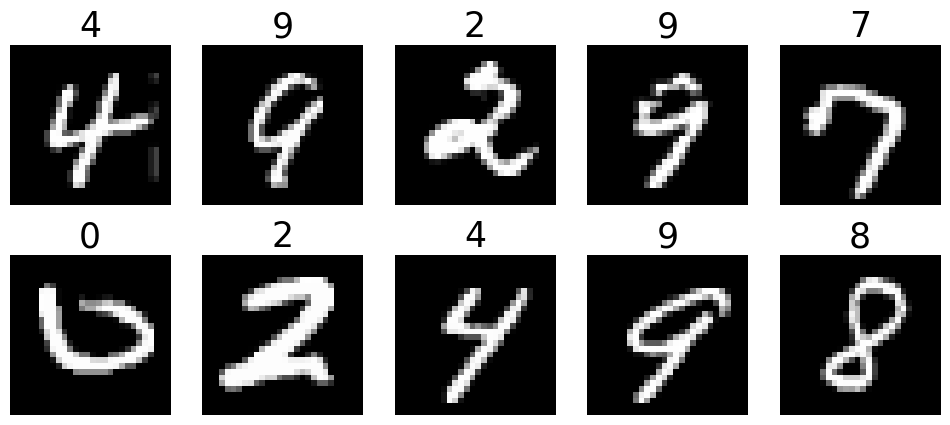

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(Y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

Redimensionando as imagens

In [ ]:
# Reshape das imagens em 3 dimensões (profundidade = -1px, altura = 28px, largura = 28px , canal = 1)
#O valor -1 é usado para indicar que o número de imagens não é especificado e deve ser calculado automaticamente pelo computador com base no tamanho total do array

X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

Convertendo os rótulos das classes

In [ ]:
# a função "to_categorical" é usada para converter os rótulos de classe em vetores de 10 posições, onde 
#cada posição representa uma classe possível. (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

Y_train = to_categorical(Y_train, num_classes = 10)

Separando os dados de treinamento e validação

In [ ]:
frac = 0.85  # fração de dados usados para treinamento
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, train_size=frac, random_state=25)

print(f"Percentual de dados para treinamento: {100*frac:.0f}%")
print(f"Total de conjuntos de dados: {Y_train.shape[0]}")
print(f"Nº de conjuntos para treinamento: {x_train.shape[0]}")
print(f"Nº de conjuntos para validação: {x_val.shape[0]}")

Percentual de dados para treinamento: 85%
Total de conjuntos de dados: 42000
Nº de conjuntos para treinamento: 35700
Nº de conjuntos para validação: 6300


Construção da arquitetura do modelo CNN

In [ ]:
model = Sequential()

# Camada de convolução 1: camada de convolução com 32 filtros, cada um com tamanho 5x5 e função de ativação ReLU. 
#A entrada é uma imagem de 28x28 pixels em tons de cinza (1 canal).
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                 activation='relu', input_shape=(28,28,1)))
                 
# Camada de convolução 2: camada de convolução com os mesmos filtros e tamanho, seguida por uma camada de max pooling de tamanho 2x2.
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', 
                 activation='relu'))

# Camada de max pooling: camada para reduzir o tamanho dos mapas de características em regiões de tamanho 2x2 mantendo apenas o valor máximo de cada região
# gerados pelas camadas de convolução anteriores. Isso ajuda a reduzir a complexidade computacional da rede e também ajuda a evitar overfitting, 
# reduzindo a redundância nas informações. 
model.add(MaxPool2D(pool_size=(2,2)))

# Camada de dropout: camada de dropout para ajudar a evitar overfitting.
model.add(Dropout(0.25))

# Camada de convolução 3: camada de convolução adicional com 64 filtros.
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                 activation='relu'))

# Camada de convolução 4: camada de convolução adicional com 64 filtros, seguida por outra camada de max pooling e dropout.
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', 
                 activation='relu'))

# Camada de max pooling
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Camada de dropout
model.add(Dropout(0.25))

# Camada de achatamento (flatten): transforma os mapas de características 3D das camadas anteriores em um vetor 1D.
model.add(Flatten())

# Camada densa (totalmente conectada): camada densa (totalmente conectada) com 256 neurônios e função de ativação ReLU, seguida por outra camada de dropout.
model.add(Dense(256, activation='relu'))

# Camada de dropout
model.add(Dropout(0.5))

# Camada de saída: camada com 10 neurônios (um para cada classe) e função de ativação softmax para produzir as probabilidades de pertencer a cada classe.
model.add(Dense(10, activation='softmax'))


Algoritmo de otimização

In [ ]:
# algoritmo de otimização utilizado em redes neurais para atualizar os pesos e os bias da rede 
# durante o processo de treinamento, a fim de minimizar a função de perda.
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

Configurando o modelo antes do treinamento

In [ ]:
# Compilando o modelo
# loss: a função de perda a ser minimizada durante o treinamento. A função de perda mede o quão bem o modelo está realizando a tarefa.
# metrics: avalia o desempenho do modelo durante o treinamento e teste. Avalia a precisão do modelo.

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Redução da taxa de aprendizagem

In [ ]:
# ReduceLROnPlateau é uma função que diminui a taxa de aprendizagem durante o treinamento quando a melhora da performance do modelo é estagnada. 
# Isso pode ajudar a melhorar a precisão do modelo, evitando que ele fique preso em um mínimo local ou divergindo completamente.
# patience: o número de épocas que o modelo pode continuar sem melhoria antes de diminuir a taxa de aprendizagem.
# factor: o fator pelo qual a taxa de aprendizagem é reduzida. Um fator de 0,5 significa que a taxa de aprendizagem é reduzida pela metade.
#min_lr: o limite mínimo para a taxa de aprendizagem. Quando a taxa de aprendizagem atinge esse valor, ela não é mais reduzida.

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Definição do número de épocas e tamanho de lote

In [ ]:
#O epochs é o número de vezes que o conjunto de dados de treinamento é passado pela rede neural durante o treinamento. 
#Em outras palavras, é o número de vezes que o algoritmo de otimização atualiza os pesos da rede neural com base na função de perda.

#O batch_size é o número de amostras de treinamento que são usadas em uma única atualização de peso. 
#Em outras palavras, é o número de amostras que a rede neural processa antes de fazer uma atualização de peso.

epochs = 10
batch_size = 86

Uso da técnica Data augmentation para prevenir overfitting

In [ ]:
datagen = ImageDataGenerator(
        featurewise_std_normalization=False,  # divide as entradas pelo desvio padrão do conjunto de dados
        rotation_range=10,  # gira aleatoriamente as imagens no intervalo de 0 a 180 graus
        zoom_range = 0.1, # Amplie a imagem aleatoriamente
        width_shift_range=0.1,  # muda aleatoriamente as imagens horizontalmente (fração da largura total)
        height_shift_range=0.1,  # muda aleatoriamente as imagens verticalmente (fração da altura total)
        horizontal_flip=False,  # vira imagens aleatoriamente de forma horizontal
        vertical_flip=False)  # vira imagens aleatoriamente de forma vertical


datagen.fit(x_train)

Novo tamanho do conjunto de treinamento

In [ ]:
x_train.size

27988800

Realização do treinamento do modelo de rede neural

In [ ]:
# 'verbose': Controla a quantidade de informação que o código deve imprimir na tela durante a execução. Quando verbose=0, nenhuma informação é impressa. 
# Quando verbose=1, o progresso do treinamento é mostrado em uma barra de progresso que atualiza a cada época. 
# Quando verbose=2, uma linha é impressa a cada época mostrando informações como tempo de execução, número de épocas e loss e acurácia para treinamento e validação.

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10


<ipython-input-53-ee8e62b8f91c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


415/415 - 20s - loss: 0.4358 - accuracy: 0.8592 - val_loss: 0.0631 - val_accuracy: 0.9817 - lr: 0.0010 - 20s/epoch - 47ms/step
Epoch 2/10


415/415 - 12s - loss: 0.1298 - accuracy: 0.9618 - val_loss: 0.0444 - val_accuracy: 0.9860 - lr: 0.0010 - 12s/epoch - 30ms/step
Epoch 3/10


415/415 - 13s - loss: 0.0938 - accuracy: 0.9712 - val_loss: 0.0341 - val_accuracy: 0.9905 - lr: 0.0010 - 13s/epoch - 30ms/step
Epoch 4/10


415/415 - 18s - loss: 0.0782 - accuracy: 0.9773 - val_loss: 0.0385 - val_accuracy: 0.9892 - lr: 0.0010 - 18s/epoch - 42ms/step
Epoch 5/10


415/415 - 12s - loss: 0.0690 - accuracy: 0.9793 - val_loss: 0.0302 - val_accuracy: 0.9898 - lr: 0.0010 - 12s/epoch - 30ms/step
Epoch 6/10


415/415 - 12s - loss: 0.0636 - accuracy: 0.9814 - val_loss: 0.0291 - val_accuracy: 0.9908 - lr: 0.0010 - 12s/epoch - 30ms/step
Epoch 7/10


415/415 - 12s - loss: 0.0584 - accuracy: 0.9824 - val_loss: 0.0335 - val_accuracy: 0.9914 - lr: 0.0010 - 12s/epoch - 30ms/step
Epoch 8/10


415/415 - 13s - loss: 0.0560 - accuracy: 0.9845 - val_loss: 0.0314 - val_accuracy: 0.9906 - lr: 0.0010 - 13s/epoch - 31ms/step
Epoch 9/10


415/415 - 13s - loss: 0.0563 - accuracy: 0.9837 - val_loss: 0.0269 - val_accuracy: 0.9914 - lr: 0.0010 - 13s/epoch - 31ms/step
Epoch 10/10


415/415 - 12s - loss: 0.0574 - accuracy: 0.9839 - val_loss: 0.0256 - val_accuracy: 0.9933 - lr: 0.0010 - 12s/epoch - 30ms/step


Plotagem das curvas de perda e precisão para treinamento e validação

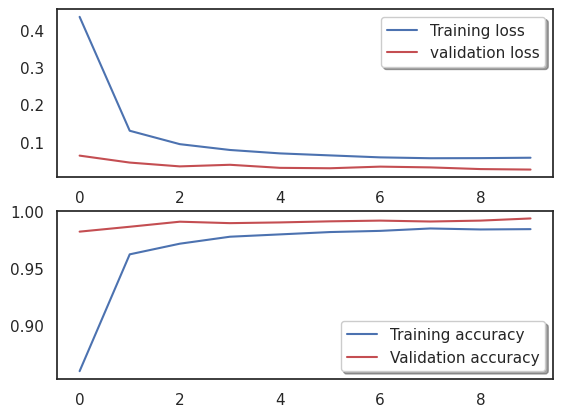

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Matriz de confusão dos 6300 dados de validação

197/197 [==============================] - 0s 2ms/step


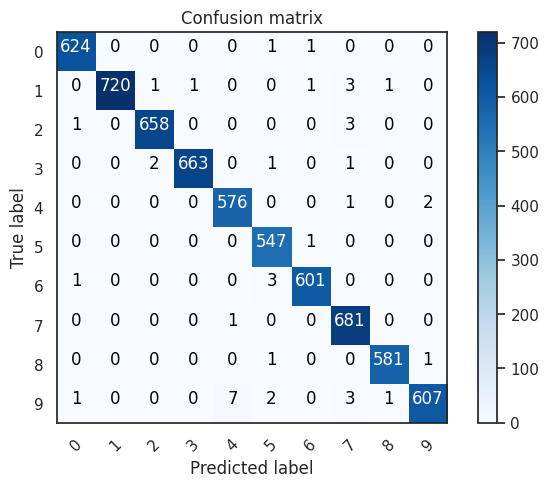

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predição dos valores do conjunto de dados de validação
Y_pred = model.predict(x_val)
# Converter classes de previsões em um vetor 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Converter os dados de validação em um vetor
Y_true = np.argmax(y_val,axis = 1) 
# computar a matriz de confusão
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plotar a matriz de confusão
plot_confusion_matrix(confusion_mtx, classes = range(10))